# Description

Notebook to compute metrics.

# Setup

In [1]:
%matplotlib notebook
%load_ext autoreload

## Imports

In [2]:
# os related
from pathlib import Path
import os 

# data related
import pandas as pd
# import missingno as msno
import datetime as dt
import numpy as np


# visual related
import matplotlib.pyplot as plt
# time related

from fonctions import *

## Paths

In [3]:

# MUST BE IN CODE FOLDER TO WORK !
PROJECT_PATH = Path(os.getcwd()).parent

RAW_DATA = PROJECT_PATH / "RAW_DATA" 
PROC_DATA = PROJECT_PATH / "PROC_DATA"

# RAW FILES
CSV_FILE = RAW_DATA / "Individual_stock_data_csv.csv"
XLSX_FILE = RAW_DATA / "Individual_stock_data.xlsx"

# PROC FILES
PROC_STOCK = PROC_DATA / "proc_stock.csv"
PROC_CARBON = PROC_DATA / "proc_carbon.csv"

STOCK_2000 = PROC_DATA / "stock_2000.csv"

STOCK_WORK = PROC_DATA / "stock_work.csv"
STOCK2USE = PROC_DATA / "stock2use.csv"
DIC2USE = PROC_DATA / "dic2use.json"


OUT_RENDEMENT = PROC_DATA / "rendement_v1.csv"

OUT_DF_CSV = PROC_DATA / "optimize_assets.csv"

# OUT_DIC_WEIGHT = PROC_DATA / "dic_weight.pickle"

## Utils

In [4]:
def compute_enc(weights):
    """Function that computes the ENC for given weights an a given window"""
    return 1 / sum([w**2 for w in weights])
    

def compute_ir(excess_return, track_err):
    """Function that computes the information ratio given 
    the excess return and the track_err"""
    return [ex_ret / track_err for (ex_ret, track_err) in zip(excess_return, track_err)]

def compute_di(weight, stock, vol_p):
    """Function that computes the diversification index"""
    stock_vol = stock.std() * np.sqrt(12)
    return np.dot(stock_vol, weight) / (vol_p * np.sqrt(12))

# Notebook


In [5]:
stock_df = read_file(STOCK2USE).iloc[104:-4]

return_df = pd.read_csv(OUT_DF_CSV)
return_df.index = read_file(STOCK2USE).index[104:-4]
return_df.drop(columns="Unnamed: 0", inplace=True)

stock_ret = stock_df.pct_change()

sp500 = read_file(STOCK_WORK)
bm_return = equally_weighted(sp500) 

return_sp = pd.DataFrame((sp500.mean(axis=1).pct_change())*100, columns=["mu"])
return_sp = return_sp.loc[return_df.index[0]:return_df.index[-1]]

In [6]:

metrics = ["ret", "vol", "sr", 
           "track_err", "yearly_track_error",
           "ex_ret", "enc", "encb", 
           "ir", "di"]


In [7]:
dic = dict.fromkeys(return_df.columns)
for k in dic.keys():
    dic[k] = dict.fromkeys(metrics)


In [8]:
# Poids pour chacun des rebalancement
dic_weight = {
    pf: pd.read_csv(PROC_DATA / f"weight_{pf}.csv").rename(columns={'Unnamed: 0':"quarter"}).set_index("quarter")
    for pf in dic.keys()
}

In [9]:
rf = 0.05

In [10]:
for pf in dic.keys():
        
    # Rendement annualisé
    dic[pf]["ret"] = return_df[pf].mean() * 52

    # Volatilité sur les 18 ans
    dic[pf]["vol"] = return_df[pf].std() * np.sqrt(52)
    
    # Ratio de sharp
    dic[pf]["sr"] = (dic[pf]["ret"] - rf) / dic[pf]["vol"]
    
     # Tracking error
    dic[pf]["track_err"] = []
    for i in range(len(return_df)//12): # par paquet de 3 mois
        dic[pf]["track_err"].append((return_df[pf].iloc[i*12:(i+1)*12] - return_sp["mu"].iloc[i*12:(i+1)*12]).std())
    
    # Tracking global error
    dic[pf]["yearly_track_err"] = []
    for i in range(len(return_df)//(12*4)): # par paquet de 1 an
        dic[pf]["yearly_track_err"].append((return_df[pf].iloc[i*12*4:(i+1)*12*4] - return_sp["mu"].iloc[i*12*4:(i+1)*12*4]).std())
    
    # Excess return 
    dic[pf]["ex_ret"] = []
    for i in range(len(return_df)//12): # par paquet de 3 mois
        dic[pf]["ex_ret"].append( 
            (return_df[pf].iloc[i*12:(i+1)*12].mean()) - (return_sp["mu"].iloc[i*12:(i+1)*12].mean())
        )
        
    # Yearly Excess return 
    dic[pf]["yearly_ex_ret"] = []
    for i in range(len(return_df)//(12*4)): # par paquet de 1 an
        dic[pf]["yearly_ex_ret"].append( 
            (return_df[pf].iloc[i*12*4:(i+1)*12*4].mean()) - (return_sp["mu"].iloc[i*12*4:(i+1)*12*4].mean())
        )

    # Calcul de l'ENC
    dic[pf]["enc"] = dic_weight[pf].apply(compute_enc, axis=1)
    
    # Information ratio
    dic[pf]["ir"] = compute_ir(dic[pf]["ex_ret"], dic[pf]["track_err"])
        
    # Yearly Information ratio
    dic[pf]["yearly_ir"] = compute_ir(dic[pf]["yearly_ex_ret"],
                                             dic[pf]["yearly_track_err"])
    
    # Diversification index # récupérer les poids
    sum_di = 0
    for i in range(len(return_df)//12):
          sum_di += compute_di(
            weight=dic_weight[pf].iloc[i],
            stock=stock_ret.iloc[i*12:(i+1)*12],
            vol_p=return_df[pf].iloc[i*12:(i+1)*12].std())
            
    print(pf)
    print(sum_di)
    dic[pf]["di"] = sum_di / (len(return_df)//12)
    
         

ew
1.5161281619472564
gmv
0.9725269264584693
maxdecor
1.301979332731861
maxdiv
1.1439020886895856
msr
1.0421172284966664


In [11]:
dic

{'ew': {'ret': 15.46086914246365,
  'vol': 16.89877855411223,
  'sr': 0.9119516592939491,
  'track_err': [1.1829968686588939,
   1.0892322732695137,
   1.0300149369949683,
   1.0675947845438125,
   1.1061082875118267,
   0.999318143388918,
   1.7556428002255908,
   1.04767495732451,
   1.0267810381440654,
   1.4279007185784265,
   1.1749534211232748,
   1.0359679719927715,
   1.556927449441648,
   1.2136624093101513,
   0.800790996902656,
   1.4339465290650826,
   1.1994873823298764,
   0.958063023175989,
   1.4319804269286607,
   1.9056979397108424,
   1.2085487867012756,
   1.4930692562573369,
   1.6414964632873643,
   0.9735427078915739,
   1.9974057408920471,
   2.4880308096024413,
   2.0798290596596885,
   1.9379963834741978,
   2.7996193621652314,
   2.378354574049002,
   3.26212165952714,
   1.6907606580564634,
   1.8271694557527225,
   1.8818142268651699,
   1.836526544311918,
   1.1624397977126917,
   1.4459614459105785,
   1.397463346492769,
   1.0901508546497032,
   1.163887

In [12]:
%store dic

Stored 'dic' (dict)


In [13]:
dic["ew"].keys()

dict_keys(['ret', 'vol', 'sr', 'track_err', 'yearly_track_error', 'ex_ret', 'enc', 'encb', 'ir', 'di', 'yearly_track_err', 'yearly_ex_ret', 'yearly_ir'])

In [14]:
dic.keys()

dict_keys(['ew', 'gmv', 'maxdecor', 'maxdiv', 'msr'])

In [15]:
dic[k]["ret"]

12.305292959206094

In [16]:
plt.figure()
plt.bar(dic.keys(),
    [dic[k]["ret"] for k in dic.keys()],
       align="center",
        width=0.4
   )

plt.title("Rendement par portefeuille", fontsize=15)
plt.ylabel("%", fontsize=15)
plt.ylim(0,22)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

<IPython.core.display.Javascript object>

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <a list of 10 Text yticklabel objects>)

In [17]:
fig, axs = plt.subplots(1, len(dic.keys())+1, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 3, 3, 3, 3, 1]})

dic_color = {'increasing':'green', 'decreasing':'red', 'no trend':'blue'}


labels = list(dic.keys())

for i, col in enumerate(return_df.columns):
    axs[i].hist(return_df[col], bins=50, density=True)
    axs[i].set_xlabel("%")
    axs[i].set_title(col, fontsize=11, pad=0.5)
    axs[i].grid(True)
    

    
lax = axs[-1]
lax.axis('off')
# lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
#lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Distribution des rendements hebdomadaires (%)")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Distribution des rendements hebdomadaires (%)')

In [18]:
plt.figure()
plt.bar(dic.keys(),
    [dic[k]["vol"] for k in dic.keys()],
       align="center",
        width=0.4)

plt.title("Ecart-Type par portefeuille", fontsize=15)
plt.ylabel("%", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

<IPython.core.display.Javascript object>

(array([ 0.,  5., 10., 15., 20., 25.]), <a list of 6 Text yticklabel objects>)

Distribution des rendements


## Tracking error

In [19]:
yr_idx = [str(i) for i in range(2001,2020)]

track_error_df = pd.DataFrame(index=yr_idx)

for k in dic.keys():
    track_error_df[k] = dic[k]["yearly_track_err"]
    
    

track_error_df.plot()    
plt.title("Tracking Error annuelle")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Tracking Error annuelle')

In [20]:
plt.figure()
for k in dic.keys():
    plt.plot(dic[k]["yearly_track_err"], label=k)
    plt.legend()
    
plt.title("Tracking Error annuelle")

ticks = [i for i in range(19)]
x_labels = [i for i in range(2001,2020)]

plt.xticks(xticks=range(19),
labels=x_labels)

plt.show()

<IPython.core.display.Javascript object>

TypeError: object of type 'NoneType' has no len()

<IPython.core.display.Javascript object>


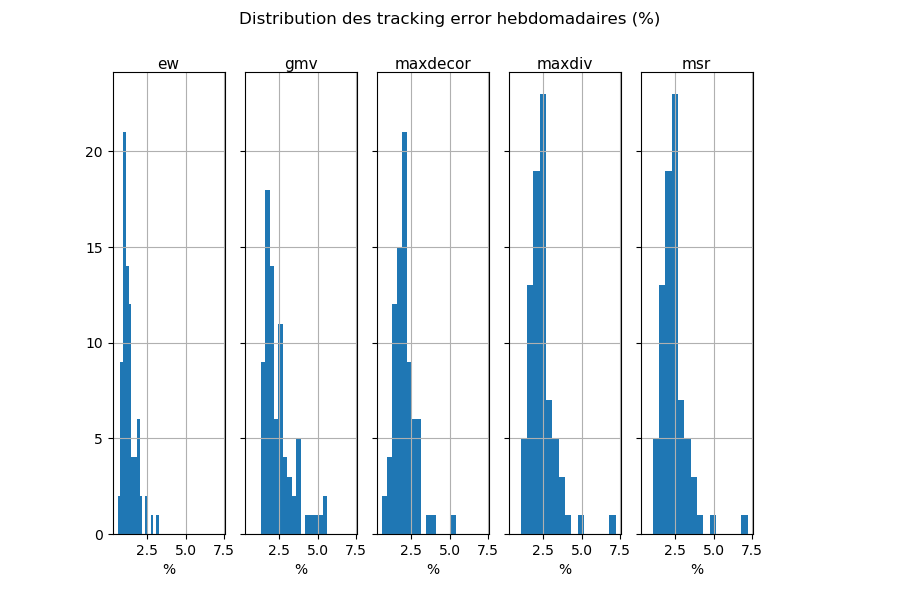

Text(0.5, 0.98, 'Distribution des tracking error hebdomadaires (%)')

In [21]:
fig, axs = plt.subplots(1, len(dic.keys())+1, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 3, 3, 3, 3, 1]})

dic_color = {'increasing':'green', 'decreasing':'red', 'no trend':'blue'}


labels = list(dic.keys())

for i, col in enumerate(return_df.columns):
    axs[i].hist(dic[col]["track_err"], bins=15)
    axs[i].set_xlabel("%")
    axs[i].set_title(f"{col}", fontsize=11, pad=0.5)
    axs[i].grid(True)
    

    
lax = axs[-1]
lax.axis('off')
# lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
#lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Distribution des tracking error hebdomadaires (%)")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

excess return

<IPython.core.display.Javascript object>


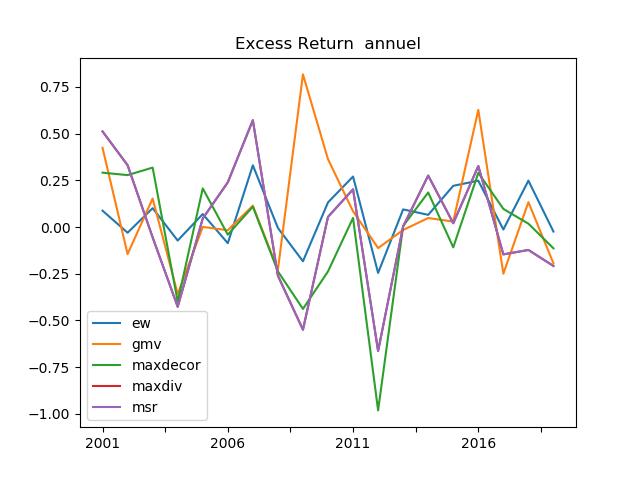

Text(0.5, 1.0, 'Excess Return  annuel')

In [22]:
yr_idx = [str(i) for i in range(2001,2020)]

ex_ret_df = pd.DataFrame(index=yr_idx)

for k in dic.keys():
    ex_ret_df[k] = dic[k]["yearly_ex_ret"]
    
    

ex_ret_df.plot()    
plt.title("Excess Return  annuel")

In [23]:
ex_ret_df

,ew,gmv,maxdecor,maxdiv,msr
2001,0.087545,0.423809,0.290996,0.511646,0.511646
2002,-0.030390,-0.144771,0.277967,0.330983,0.330983
2003,0.100957,0.152672,0.318134,-0.055337,-0.055337
2004,-0.072290,-0.358647,-0.399250,-0.426925,-0.426925
2005,0.069528,0.000567,0.206872,0.045724,0.045724
2006,-0.086441,-0.016954,-0.040967,0.239270,0.239270
2007,0.330304,0.114159,0.109015,0.571736,0.571736
2008,-0.004782,-0.228960,-0.237260,-0.260496,-0.260496
2009,-0.183223,0.816974,-0.438276,-0.549597,-0.549597
2010,0.131860,0.363062,-0.237441,0.054434,0.054434


In [24]:
ex_ret_df.style.background_gradient(cmap="Blues")

,ew,gmv,maxdecor,maxdiv,msr
2001,0.087545,0.423809,0.290996,0.511646,0.511646
2002,-0.030390,-0.144771,0.277967,0.330983,0.330983
2003,0.100957,0.152672,0.318134,-0.055337,-0.055337
2004,-0.072290,-0.358647,-0.399250,-0.426925,-0.426925
2005,0.069528,0.000567,0.206872,0.045724,0.045724
2006,-0.086441,-0.016954,-0.040967,0.239270,0.239270
2007,0.330304,0.114159,0.109015,0.571736,0.571736
2008,-0.004782,-0.228960,-0.237260,-0.260496,-0.260496
2009,-0.183223,0.816974,-0.438276,-0.549597,-0.549597
2010,0.131860,0.363062,-0.237441,0.054434,0.054434


<IPython.core.display.Javascript object>


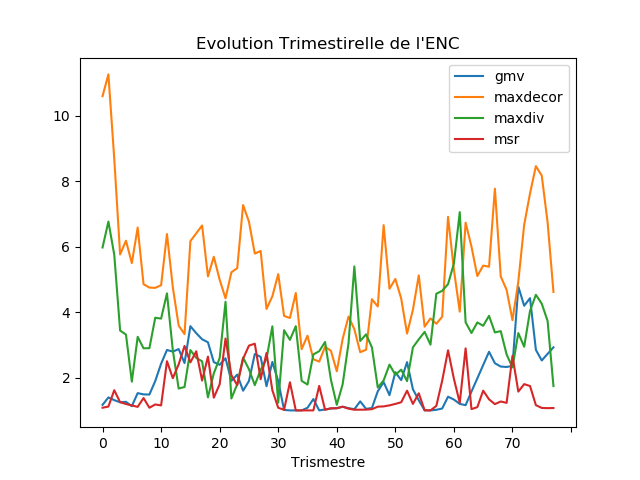

Text(0.5, 0, 'Trismestre')

In [244]:
yr_idx = [str(i) for i in range(len(dic["ew"]["enc"]))]

enc_df = pd.DataFrame(index=yr_idx)

for k in list(dic.keys())[1:]:
    enc_df[k] = dic[k]["enc"].values
    
    

enc_df.plot()    
plt.title("Evolution Trimestirelle de l'ENC")
plt.xlabel("Trismestre")

Information ratio

<IPython.core.display.Javascript object>


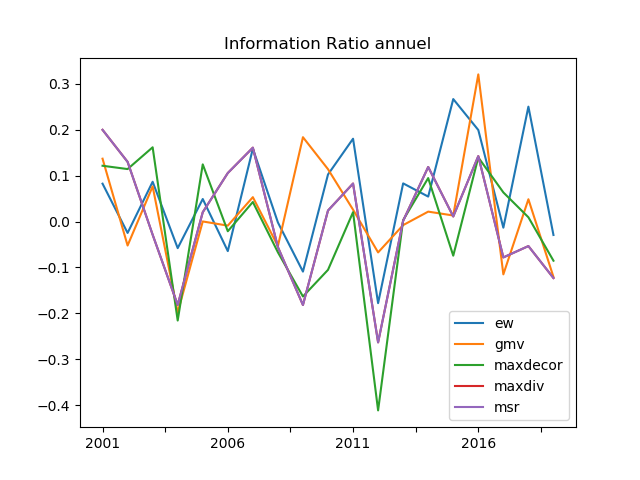

Text(0.5, 1.0, 'Information Ratio annuel')

In [157]:
yr_idx = [str(i) for i in range(2001,2020)]

ir_df = pd.DataFrame(index=yr_idx)

for k in dic.keys():
    ir_df[k] = dic[k]["yearly_ir"]

ir_df.plot()    
plt.title("Information Ratio annuel")

In [158]:
ir_df.style.background_gradient(cmap="Blues")

,ew,gmv,maxdecor,maxdiv,msr
2001,0.082558,0.136995,0.121607,0.199868,0.199868
2002,-0.024755,-0.052177,0.114389,0.130069,0.130069
2003,0.086714,0.076649,0.161829,-0.028653,-0.028653
2004,-0.057886,-0.197862,-0.215579,-0.181672,-0.181672
2005,0.049148,0.000260,0.124596,0.020339,0.020339
2006,-0.064331,-0.008861,-0.021072,0.105782,0.105782
2007,0.158957,0.053157,0.042617,0.161030,0.161030
2008,-0.001866,-0.053437,-0.066957,-0.055651,-0.055651
2009,-0.109009,0.183827,-0.163189,-0.181787,-0.181787
2010,0.102581,0.114129,-0.105189,0.024030,0.024030


sharp ratio

<IPython.core.display.Javascript object>


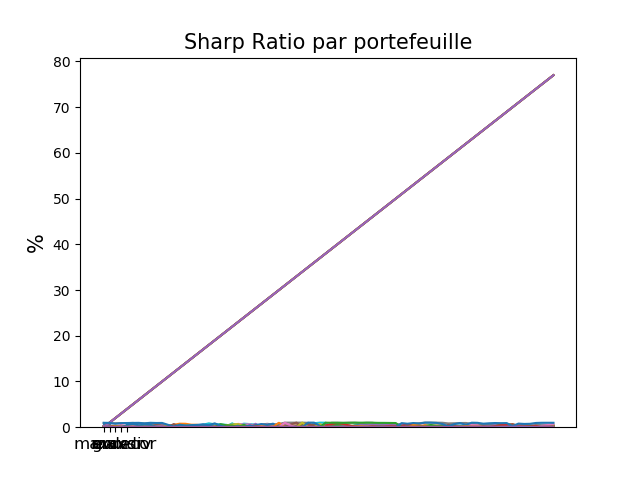

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

In [160]:
plt.figure()
plt.bar(dic.keys(),
    [dic[k]["sr"] for k in dic.keys()],
       align="center",
        width=0.4)

plt.title("Sharp Ratio par portefeuille", fontsize=15)
plt.ylabel("%", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

### analysis

- Récupérer table de poids
- Calculer poids moyen sur les 20 ans
- Analyser les 3 plus gros poids pour les 5 portefeuilles

In [173]:
path = f"weight_{w}.csv"
df = pd.read_csv(PROC_DATA / path)
df.mean().sort_values(ascending=False)[1:4]


pld     0.477815
viac    0.198780
el      0.091112
dtype: float64

<IPython.core.display.Javascript object>


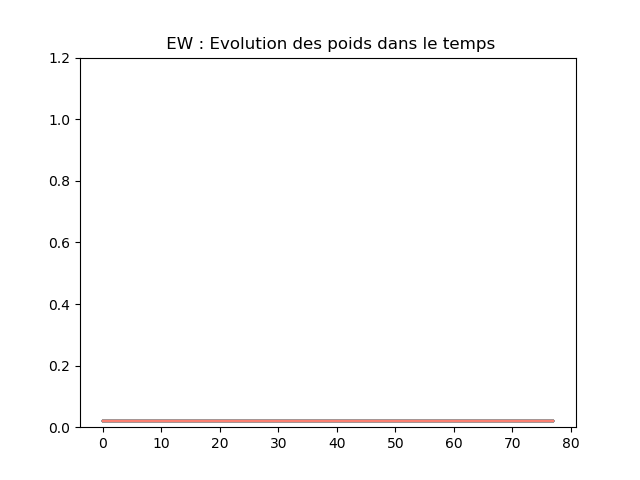

EW
unh    0.02
slb    0.02
bkr    0.02
dtype: float64 



<IPython.core.display.Javascript object>


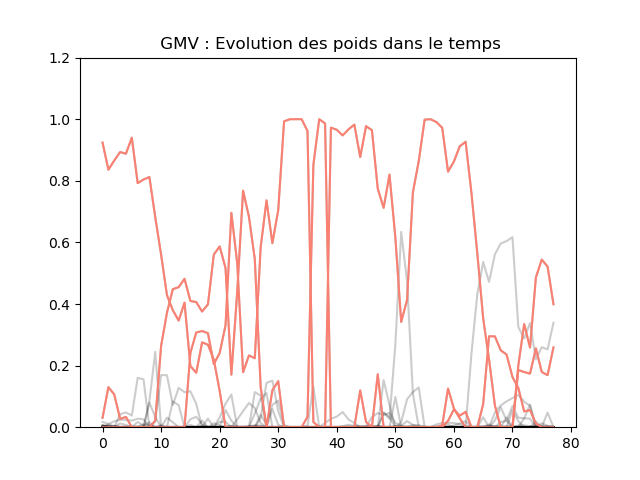

GMV
pld     0.474084
el      0.172455
viac    0.168027
dtype: float64 



<IPython.core.display.Javascript object>


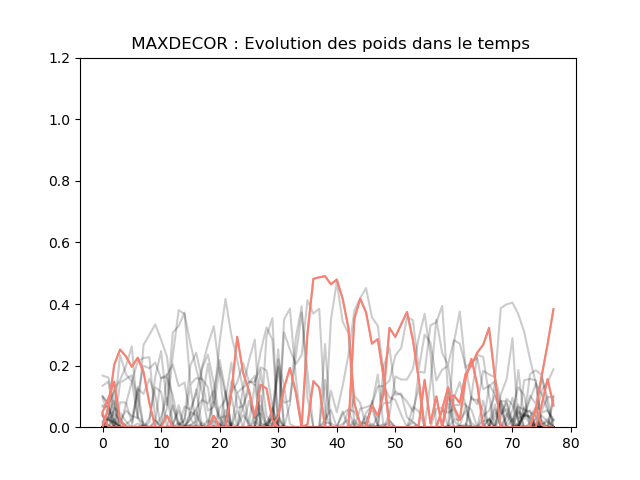

MAXDECOR
exc    0.075090
ed     0.063482
hal    0.053370
dtype: float64 



<IPython.core.display.Javascript object>


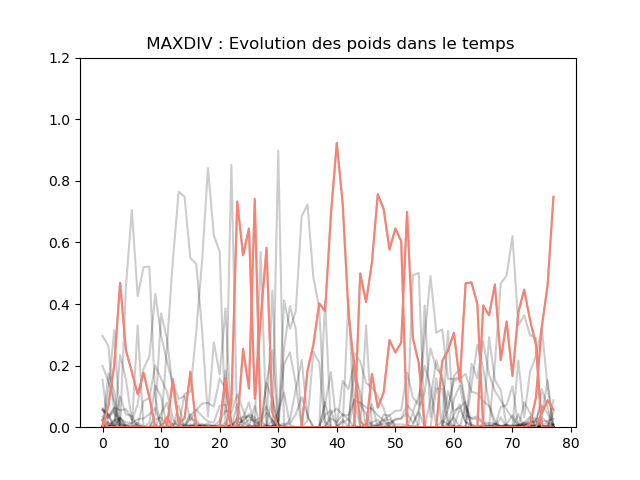

MAXDIV
bkr    0.125380
hal    0.109728
exc    0.085999
dtype: float64 



<IPython.core.display.Javascript object>


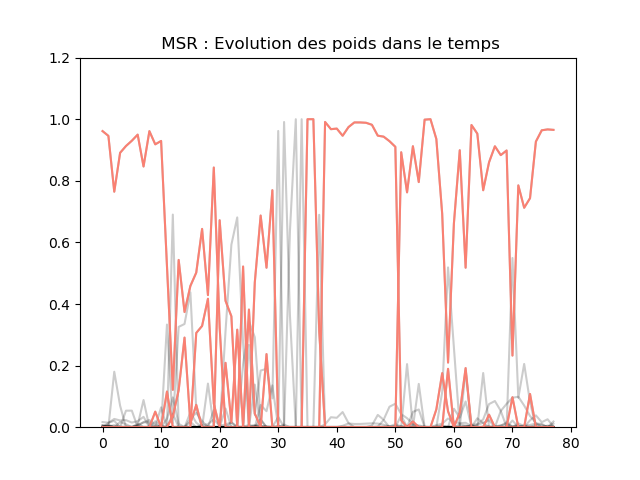

MSR
pld     0.477815
viac    0.198780
el      0.091112
dtype: float64 



In [224]:
# Itérer sur les 5 portefeuille

for w in dic.keys():
    plt.figure()    
    path = f"weight_{w}.csv"
    df = pd.read_csv(PROC_DATA / path)
    print(w.upper())
    print(df.mean().sort_values(ascending=False)[1:4], "\n")
    top_assets = df.mean().sort_values(ascending=False)[1:4].index.tolist()
    df.drop(columns='Unnamed: 0', inplace=True)
    
    
    plt.plot(df.loc[:, ~df.columns.isin([top_assets])], color="black", alpha=0.2)
    plt.plot(df[top_assets], color="salmon")
    plt.title(f" {w.upper()} : Evolution des poids dans le temps")
    plt.ylim(0,1.2)
    
    
#     plt.figure()    
#     plt.plot(stock_ret.loc[:, stock_ret.columns.isin([df.columns])], color="black", alpha=0.2)
#     plt.plot(stock_ret[top_assets], color="salmon")
#     plt.title(f" {w.upper()} : Evolution des rendements dans le temps")
#     # plt.ylim(0,1.2)
    
    
    
    
    
    


Spider plot

In [32]:
kpi_list = ["ret", "enc", "vol", "ex_ret", "track_err"]



In [50]:
import plotly.graph_objects as go



for k in dic.keys():
    values = [np.mean(dic[k][kpi]) for kpi in kpi_list]
    
    values[3] *= 10
    values[4] *= 10
    

    fig = go.Figure(data=go.Scatterpolar(
      r=values,
      theta=kpi_list,
      fill='toself'
    ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True
        ),
      ),
      showlegend=False
    )

    
    fig.show()